# 09.03 Margins

The support vector machine (SVM) was, for a long time, one of the most advanced ML techniques.
It fits a surface between the classes (or through a regressed function)
in a way to contain as big margins towards the data points as possible.
For classification the SVM attempts to have as big margins
(distances from the fitted surface) as possible form the classes;
for regression the SVM attempt to fit as many data points within the margins.

![Borders](sl-europe.svg)

<div style="text-align:right;"><sup>sl-europe.svg</sup></div>

<div style="border: 0.3em double teal; border-radius: 0.5em; padding: 0.5em;">
    The satirical war map of 1877 was the first widely available color print.
    Its popularity is due to the quality of the work and of the improvements
    in color printing technology, which made the print affordable to many.
    The map of Europe presented does not only show the country borders
    within Europe at the time but also the anxieties of the people
    within these countries at the time.
    The use of an octopus to draw a country which is spreading its
    influences started with the war map of 1877 and has been reused
    and remixed ever since.
</div>

SVMs are therefore often called *max-margin* classifiers (or regressors).
The technique works very well in high dimensions but becomes considerably
slow when faced with too many (millions) samples.
In other words, the SVMs were replaced by newer techniques in big data processing.
That said, SVMs are some of the best binary classifiers when not faces with millions of samples.

We import the common suspects, some more advanced plotting,
and `make_blobs` dataset generator.
The `make_circles` dataset generator is a different dataset builder
for a non-linear problem, it build two concentric circles.
Finally `SVC` stands for the Support Vector Classifier model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-talk')
from sklearn.datasets import make_blobs, make_circles
from mpl_toolkits import mplot3d
from sklearn.svm import SVC

Before attempting an SVM let's try to find good ways of classifying two classes
by placing a surface between them.
In high dimensions the surface is a hyperplane but in two dimensions it
reduces to a straight line.

To classify two classes we want something the line to separate them.
The simple (perhaps naive) approach is to:

1. find the center of each class
2. draw a line between the two centers
3. find the middle point between the centers
4. find the perpendicular line that passes through the middle point
5. use this last line as the decision function between the two classes

This, let's call it *mean distance separator*, works.
In practice it performs a very simple algorithm of finding the closest class center.
In other words, when we predict using this decision function
we just search for the closest class center as the value for the prediction.

This is very fast and very easy to code.
We could even say that it is a linear form of Naive Bayes.
Yet, this is not very accurate when classes are close or even interleaved with each other.
Let's do some algebra and try this algorithm out.
The mathematics here are just the algorithm described above.
The plotting may be complex here but it isn't anything we did not see before.

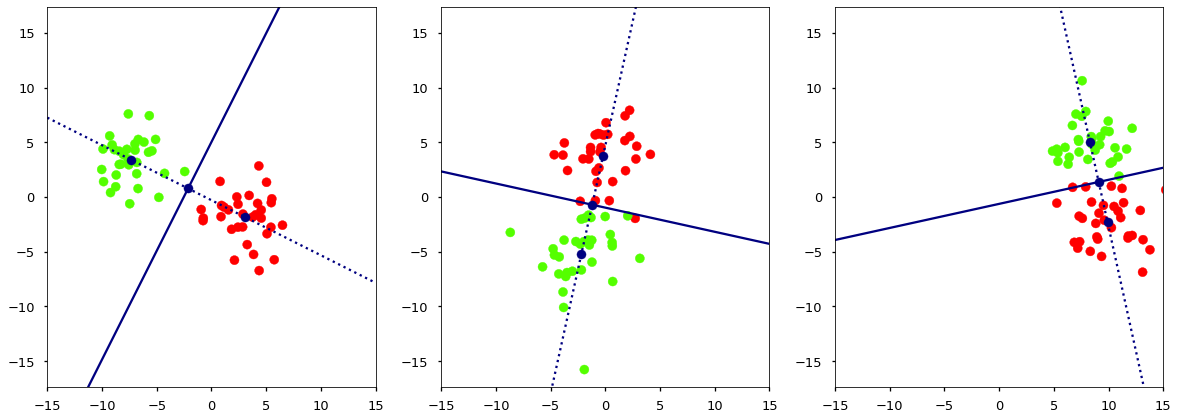

In [2]:
blob_range = (-15, 15)
blobs = []
n_blob = 3
for i in range(n_blob):
    blobs.append(make_blobs(64, centers=2, cluster_std=2.2))

def naive_separation(blobs, blob_num, ax):
    X, y = blobs[blob_num]
    center0 = X[y == 0, :].mean(axis=0)
    center1 = X[y == 1, :].mean(axis=0)
    incline = (center1[1] - center0[1]) / (center1[0] - center0[0])
    intercept = center0[1] - incline*center0[0]
    middle = (center1 + center0)/2
    invinc = -1/incline
    invinter = middle[1] - invinc*middle[0]

    x_fun = np.linspace(*blob_range, 10)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='prism')
    ax.scatter(center0[0], center0[1], c='navy')
    ax.scatter(center1[0], center1[1], c='navy')
    ax.scatter(middle[0], middle[1], c='navy')
    ax.plot(x_fun, incline*x_fun + intercept, color='navy', linestyle=':')
    ax.plot(x_fun, invinc*x_fun + invinter, color='navy', linestyle='-')
    ax.axis('equal')
    ax.set(xlim=blob_range, ylim=blob_range)

fig, axi = plt.subplots(1, n_blob, figsize=(20, 7))
for i in range(n_blob):
    naive_separation(blobs, i, axi.flat[i])

Sometimes it gets it right, sometimes not quite.
And in higher dimensional space this becomes worse,
because the algorithm does not have a way to tune the slope in specific dimensions.
Note also that every time we run the code we get different blobs
but our algorithm works nevertheless.

Instead let's try an SVM.
This attempt to build a margin between the decision (hyper)plane and the closest samples of each class.
We want a big margin therefore we attempt to fit a (hyper)plane through the current dimensions.
The slope of this (hyper)plane is $w$, which is a vector since we have a slope in each dimension.
This algorithms attempts to minimize the following.

$$
\min_{w, b} \frac{1}{2} w^T \cdot w \\
\texttt{subject to } y_i (w^T \cdot x_i + b) \ge 1, \texttt{ for i as every data point}
$$

This is a form of *quadratic programming* (QP),
which attempts to solve a convex problem with *constraints*.
Several QP procedures exist in `scipy` but `SVC` (Support Vector Classifier) already does this for us.
We will try to fit such a (hyper)plane - here a line - on the blobs above.
The hyperparameter `C=200` is just a big value in order for the SVMs
to optimize the equation above.
In reality the SVM optimizes a slightly more complex function but
with a large value for `C` it converges onto the function above.
This kind of SVM (with a very big value for `C`) is called a hard margin SVM.
A *hard margin SVM* must have all points from one class on one side of the margin
and all points from the other class on the other side.
If the classes are close together that may result in a bad solution.

The trained model contains the inclines (the spatial parameters) in `coef_`
and the constant parameters (the intercept in case of the line) in `intercept_`.
There are also `dual_coef_` parameters containing the actual optimized
parameters in the QP programming dual problem optimization,
these can be quite difficult to interpret.
In the plot `facecolor='none'` combined with `edgecolor='navy'`
makes circles around the support vectors.
In other words, the support vectors are the points in the dataset
the SVM uses to build its margins.

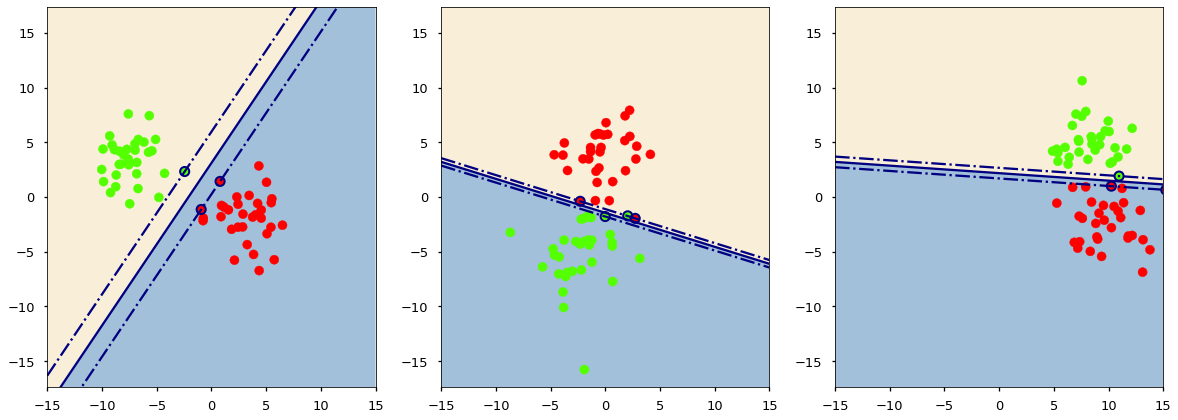

In [3]:
def svc_separation(blobs, blob_num, ax, svm_C=200):
    X, y = blobs[blob_num]
    model = SVC(C=svm_C, kernel='linear')
    model.fit(X, y)

    incline = - model.coef_[0][0] / model.coef_[0][1]
    x_decision = np.linspace(*blob_range, 128)
    y_decision = incline*x_decision - model.intercept_[0] / model.coef_[0][1]

    margin = 1 / np.sqrt(np.sum(model.coef_[0] ** 2))
    y_up = y_decision + np.sqrt(1 + incline ** 2) * margin
    y_down = y_decision - np.sqrt(1 + incline ** 2) * margin

    ax.fill_between(x_decision, -20, y_decision, facecolor='steelblue', alpha=0.5)
    ax.fill_between(x_decision, 20, y_decision, facecolor='wheat', alpha=0.5)
    ax.plot(x_decision, y_decision, color='navy')
    ax.plot(x_decision, y_up, color='navy', linestyle='-.')
    ax.plot(x_decision, y_down, color='navy', linestyle='-.')
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='prism')
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
               facecolor='none', edgecolors='navy', linewidths=2)
    ax.axis('equal')
    ax.set(xlim=blob_range, ylim=blob_range)


fig, axi = plt.subplots(1, n_blob, figsize=(20, 7))
for i in range(n_blob):
    svc_separation(blobs, i, axi.flat[i])

That's better, with the margins we often get a decision function that generalizes well.
Yet, if the margin is small, we often see that we could find a better function.
Enter *soft margin SVMs*.
If we could allow some points to be inside the margin,
we would make for bigger margins.
We add an extra parameter to the minimization problem.

$$
\min_{w, b, \zeta} \frac{1}{2} w^T \cdot w + C \sum \zeta_i\\
\texttt{subject to } y_i (w^T \cdot x_i + b) \ge 1 - \zeta_i, \texttt{ for i as every data point}
$$

This translates into a model hyperparameter the `C` in SVMs.
The smaller the parameter the more points we can allow within the margin.
The `C` hyperparameter is again an *inverse regularization*,
it works in a similar way to model regularization
but the smaller its value the more regularized the model is.

In the equation the $w$ are the model parameters,
a vector with one coordinate per dimension in which the model fits the (hyper)plane.
The $x_i$ is a single data sample in the same number of dimensions.
$b$ is the intercept parameter.
And $y_i$ is the class, either $1$ or $-1$ in the SVM formulation.
Without considering the $\zeta$ the entire "subject to" line
is just a way of writing that every point should be on the correct side
of the margin.

The $\zeta_i$ exist for points on the wrong side of the margin,
i.e. if all points are on the right side of the margin
all $\zeta_i$ are $0$ and the value of `C` does not matter.
But whenever some points are on the wrong side of the margin
then the corresponding $\zeta_i$ is $1$ and the "subject to"
line becomes non-binding for that point.
Instead for the point on the wrong side of the margin it
is the value of the `C` hyperparameter that weights
directly into the minimization.

In practice all SVMs in `sklearn` are soft margin SVMs.
Since even for very big values of `C` there may still be points
o the wrong side of the margin if the classes are joined together.
But a high value of `C` reduces the size of the margins.
Note that a tiny value of `C` would consider all points and would
hence reduce to our earlier algorithm of distance to the class center.

Let's use a small `C` on the same problem to see the margins.

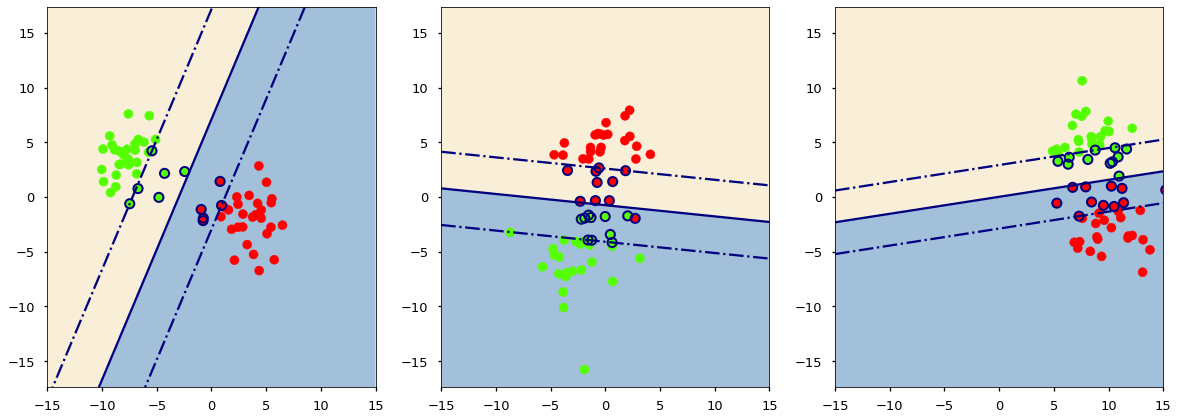

In [4]:
fig, axi = plt.subplots(1, n_blob, figsize=(20, 7))
for i in range(n_blob):
    svc_separation(blobs, i, axi.flat[i], svm_C=0.01)

We got better margins alright.
We have been marking the *support vectors* in the graphs above.
The support vectors are the points within or on the border of the margins.
A trained SVM keeps track of the support vectors only and classifies based on that alone.
Once trained the SVM only remembers the position of the support vectors,
and forgets all other data points.
This also means that the smaller `C` is the model is likely better but also uses more memory
to keep the support vectors positions.

## Kernels

But what if a line clearly won't do?
The real power of SVMs is the fact that they work well in very high dimensions,
therefore we can throw our data into a very high dimensional space and fit the hyperplane there.
Here is a blob that cannot be easily classified using a line between the classes.

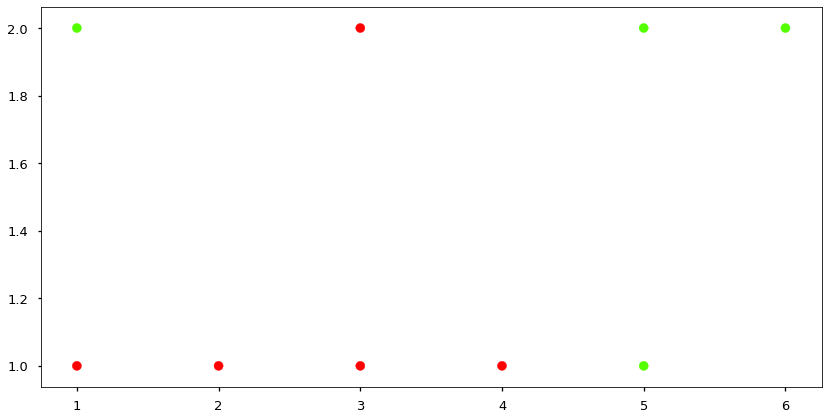

In [5]:
X = np.array([[1, 1], [1, 2], [2, 1], [3, 1], [3, 2], [4, 1], [5, 1], [5, 2], [6, 2]])
y = np.array([0, 1, 0, 0, 0, 0, 1, 1, 1])
fig, ax = plt.subplots(figsize=(14, 7))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap='prism');

We could add polynomial features to it and then fit the SVM, and that will work.
Yet the SVM itself can do it for us.
It has a `kernel=` parameter which we will set to `poly` (polynomial).

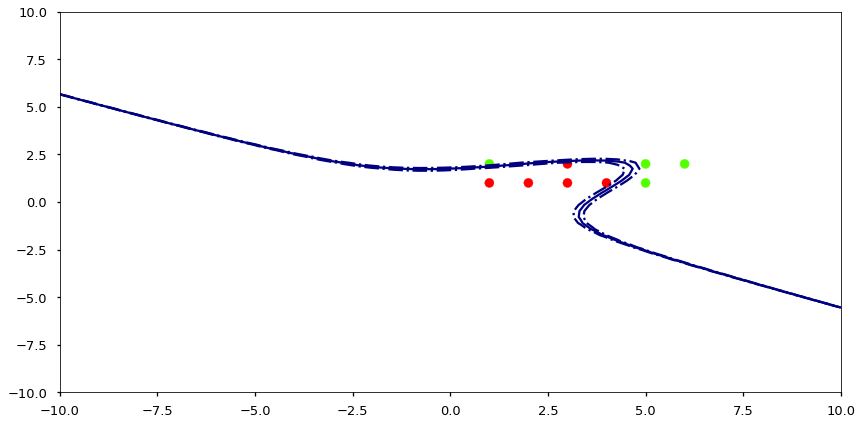

In [6]:
model = SVC(kernel='poly', C=100)
model.fit(X, y)
xg, yg = np.meshgrid(np.linspace(-10, 10, 64), np.linspace(-10, 10, 64))
zg = model.decision_function(np.c_[xg.reshape(-1), yg.reshape(-1)])

fig, ax = plt.subplots(figsize=(14, 7))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap='prism');
ax.contour(xg, yg, zg.reshape(xg.shape),
           colors='navy', linestyles=['-.', '-', '-.'], levels=[-.5, 0, .5])
ax.set(xlim=(-10, 10), ylim=(-10, 10));

If you try a pipeline with polynomial features and then compare against a polynomial SVM,
you will find that the SVM is much faster.  Why is that?

Making extra features from polynomials adds dimensions to our dataset.
During the solution to the SVM QP problem a *kernel trick* is possible.
The kernel trick is a simplification that uses a kernel identity
that simplifies the higher dimensional space.
In other words, instead of actually projecting the data into higher dimension space,
we keep that data in the same dimensions but substitute a kernel expression once
the data in high dimensional space is needed.

All this only works because of a specific way of solving QP problems,
and the fact that a kernel must abide by several properties.
The identity is that we can define a kernel $\kappa$ so that the following holds true.

$$
\kappa(x) \cdot \kappa(y) = \kappa(x, y)
$$

This prevents us from calculating a, possibly huge, dot product.
The typical SVM kernels are as follows.

- Linear Kernel (`linear`)
  $\kappa(x) = x \leftrightarrow \kappa(x, y) = x^T \cdot y$
- Polynomial Kernel (`poly`)
  $\kappa(x) = x^d \leftrightarrow \kappa(x, y) = (\eta x \cdot y + \rho)^d$
- Radial Basis Function Kernel (`rbf`)
  $\kappa(x) = e^{-x^2} \leftrightarrow \kappa(x, y) = e^{-\eta (x - y)^2}$

The mathematics behind SVMs can be daunting.
We only touch a few pieces from the surface here.
Yet, we can have a look at why a kernel works for problems where a line
would certainly not.

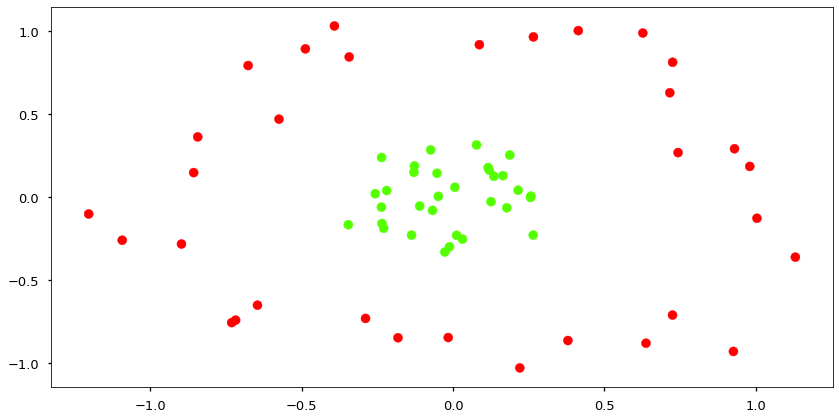

In [7]:
X, y = make_circles(64, factor=0.2, noise=0.1)
fig, ax = plt.subplots(figsize=(14, 7))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap='prism');

Neither a line or a polynomial will do here.
But we have that Radial Basis Function Kernel, and the equation for a simple
*Gaussian Radial Basis Function* is:

$$
\phi(x) = e^{-x^2}
$$

Let's apply that as a way of throwing the data into higher dimensional space.
Note that the code is simply the application of the function above to the data.

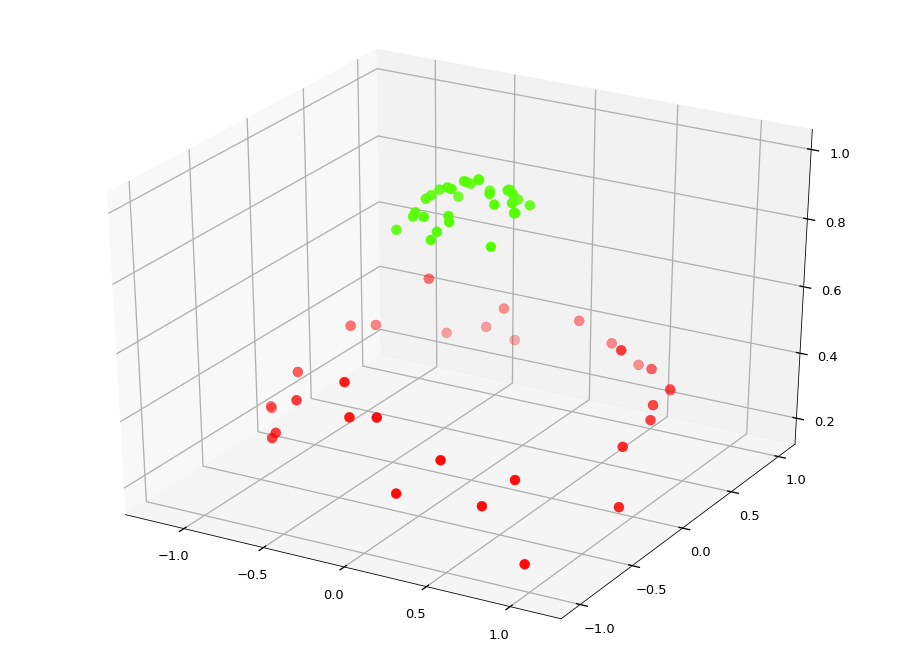

In [8]:
grbf = np.exp(-(X ** 2).sum(axis=1))
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], grbf, c=y, s=100, cmap='prism');

And it is quite easy to fit a (hyper)plane through the middle of the classes now.

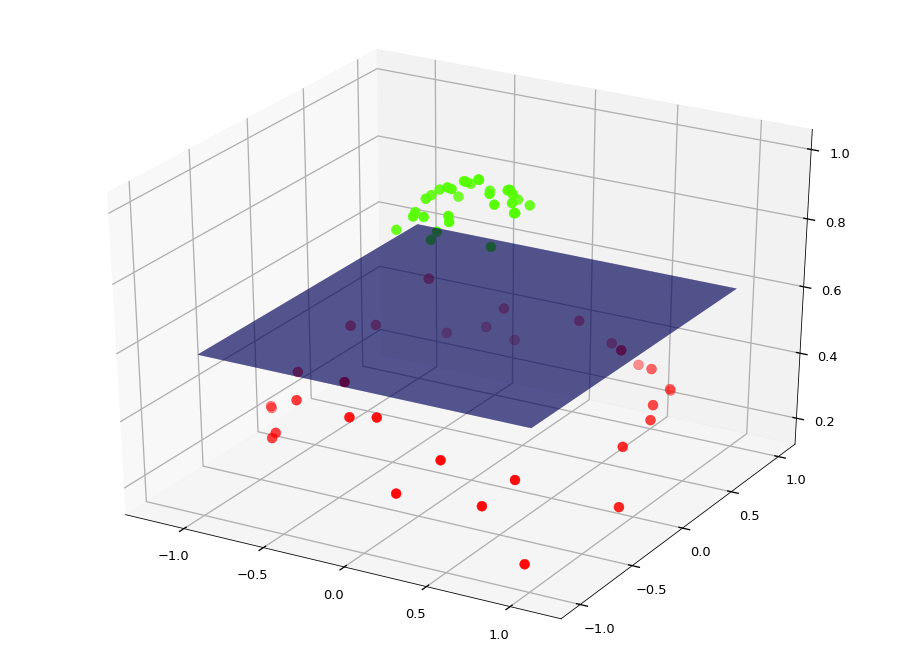

In [9]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], grbf, c=y, s=100, cmap='prism');
gx, gy = np.meshgrid([-1, 1, -1, 1], [-1, -1, 1, 1])
z = np.zeros(gx.shape) + 0.6
ax.plot_surface(gx, gy, z, alpha=0.3, color='navy');

If we build an SVM with an `rbf` kernel for this is more-or-less the solution we would find.
This specific problem was easy because the circles we concentric on the origin.
The radial basis function depends on which point to center the origin at.

The SVM kernel trick with the `rbf` kernel projects the data into an infinite number of dimensions,
one dimension for every possible move of the data so the origin is at a different point.
Of course, storing data in an infinite number of dimensions is impossible,
the projection never actually happens due to the kernel trick.
The mathematics here can again be daunting but the take away message is that
the `rbf` kernel is not limited to radial blobs concentric on the origin.
It can move the origin around and find the correct placement
for the radial basis function so that the classes can be separated.

## References

- [SciKit Learn - SVM margins][1]
- [SciKit Learn - SVM kernels][2]

[1]: http://scikit-learn.org/stable/auto_examples/svm/plot_svm_margin.html
[2]: http://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html